In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets, models, transforms
import time

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
NUM_EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NOISE_MEAN = 0.0
NOISE_VAR = 0.05
NOISE_STD = np.sqrt(NOISE_VAR)
epochs_range = range(1, NUM_EPOCHS + 1)

In [6]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

In [7]:
transform_normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])


In [8]:
transform_train_noisy = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(mean=NOISE_MEAN, std=NOISE_STD),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

In [9]:
train_dataset_clean = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_normalize)
train_loader_clean = torch.utils.data.DataLoader(
    train_dataset_clean, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


In [10]:
train_dataset_noisy = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train_noisy)
train_loader_noisy = torch.utils.data.DataLoader(
    train_dataset_noisy, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [11]:
test_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_normalize)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [12]:
def create_model():

    model = torchvision.models.resnet18(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 100)
    return model.to(device)

In [ ]:
def train_model(model, train_loader, test_loader, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())


        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_val_loss = val_loss / len(test_loader)
        epoch_val_acc = 100 * correct / total

        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, '
              f'Val Acc: {epoch_val_acc:.2f}%')

    return history


In [ ]:
print("Training Model on CLEAN Data:")
model_clean = create_model()
history_clean = train_model(model_clean, train_loader_clean, test_loader, NUM_EPOCHS)


Training Model on CLEAN Data:


Epoch [1/20], Train Loss: 3.4609, Val Loss: 3.1507, Val Acc: 22.89%


Epoch [2/20], Train Loss: 2.7157, Val Loss: 2.6418, Val Acc: 32.29%


Epoch [3/20], Train Loss: 2.3051, Val Loss: 2.4623, Val Acc: 36.81%


Epoch [4/20], Train Loss: 2.0138, Val Loss: 2.3575, Val Acc: 40.09%


Epoch [5/20], Train Loss: 1.7501, Val Loss: 2.2529, Val Acc: 42.24%


Epoch [6/20], Train Loss: 1.5057, Val Loss: 2.2638, Val Acc: 42.56%


Epoch [7/20], Train Loss: 1.2663, Val Loss: 2.2675, Val Acc: 44.19%


Epoch [8/20], Train Loss: 1.0261, Val Loss: 2.4016, Val Acc: 44.01%


Epoch [9/20], Train Loss: 0.7886, Val Loss: 2.5302, Val Acc: 43.82%


Epoch [10/20], Train Loss: 0.5981, Val Loss: 2.7323, Val Acc: 43.69%


Epoch [11/20], Train Loss: 0.4525, Val Loss: 2.9460, Val Acc: 43.37%


Epoch [12/20], Train Loss: 0.3581, Val Loss: 3.1055, Val Acc: 43.40%


Epoch [13/20], Train Loss: 0.2884, Val Loss: 3.2798, Val Acc: 44.22%


Epoch [14/20], Train Loss: 0.2353, Val Loss: 3.4155, Val Acc: 43.61%


Epoch [15/20], Train Loss: 0.2315, Val Loss: 3.4018, Val Acc: 44.22%


Epoch [16/20], Train Loss: 0.2003, Val Loss: 3.5898, Val Acc: 43.88%


Epoch [17/20], Train Loss: 0.1960, Val Loss: 3.6811, Val Acc: 43.72%


Epoch [18/20], Train Loss: 0.1611, Val Loss: 3.7530, Val Acc: 44.06%


Epoch [19/20], Train Loss: 0.1640, Val Loss: 3.8159, Val Acc: 43.49%


Epoch [20/20], Train Loss: 0.1676, Val Loss: 3.9886, Val Acc: 43.30%


In [ ]:
print("Training Model on NOISY Data")
model_noisy = create_model()
history_noisy = train_model(model_noisy, train_loader_noisy, test_loader, NUM_EPOCHS)


Training Model on NOISY Data


Epoch [1/20], Train Loss: 3.6588, Val Loss: 4.2856, Val Acc: 11.20%


Epoch [2/20], Train Loss: 3.0985, Val Loss: 4.0420, Val Acc: 16.16%


Epoch [3/20], Train Loss: 2.7945, Val Loss: 3.3323, Val Acc: 23.13%


Epoch [4/20], Train Loss: 2.5676, Val Loss: 3.5557, Val Acc: 23.29%


Epoch [5/20], Train Loss: 2.4000, Val Loss: 3.3215, Val Acc: 24.78%


Epoch [6/20], Train Loss: 2.2341, Val Loss: 3.2036, Val Acc: 27.11%


Epoch [7/20], Train Loss: 2.0869, Val Loss: 3.3565, Val Acc: 26.10%


Epoch [8/20], Train Loss: 1.9404, Val Loss: 3.2899, Val Acc: 27.81%


Epoch [9/20], Train Loss: 1.7966, Val Loss: 3.0151, Val Acc: 31.15%


Epoch [10/20], Train Loss: 1.6569, Val Loss: 3.4444, Val Acc: 28.34%


Epoch [11/20], Train Loss: 1.5093, Val Loss: 3.0456, Val Acc: 32.76%


Epoch [12/20], Train Loss: 1.3602, Val Loss: 3.2081, Val Acc: 32.70%


Epoch [13/20], Train Loss: 1.2247, Val Loss: 3.4101, Val Acc: 30.58%


Epoch [14/20], Train Loss: 1.0926, Val Loss: 3.2877, Val Acc: 33.22%


Epoch [15/20], Train Loss: 0.9678, Val Loss: 3.4463, Val Acc: 32.58%


Epoch [16/20], Train Loss: 0.8605, Val Loss: 3.5379, Val Acc: 32.94%


Epoch [17/20], Train Loss: 0.7681, Val Loss: 3.5998, Val Acc: 33.23%


Epoch [18/20], Train Loss: 0.6869, Val Loss: 3.7900, Val Acc: 32.45%


Epoch [19/20], Train Loss: 0.6273, Val Loss: 3.7971, Val Acc: 33.69%


Epoch [20/20], Train Loss: 0.5623, Val Loss: 4.0254, Val Acc: 32.45%


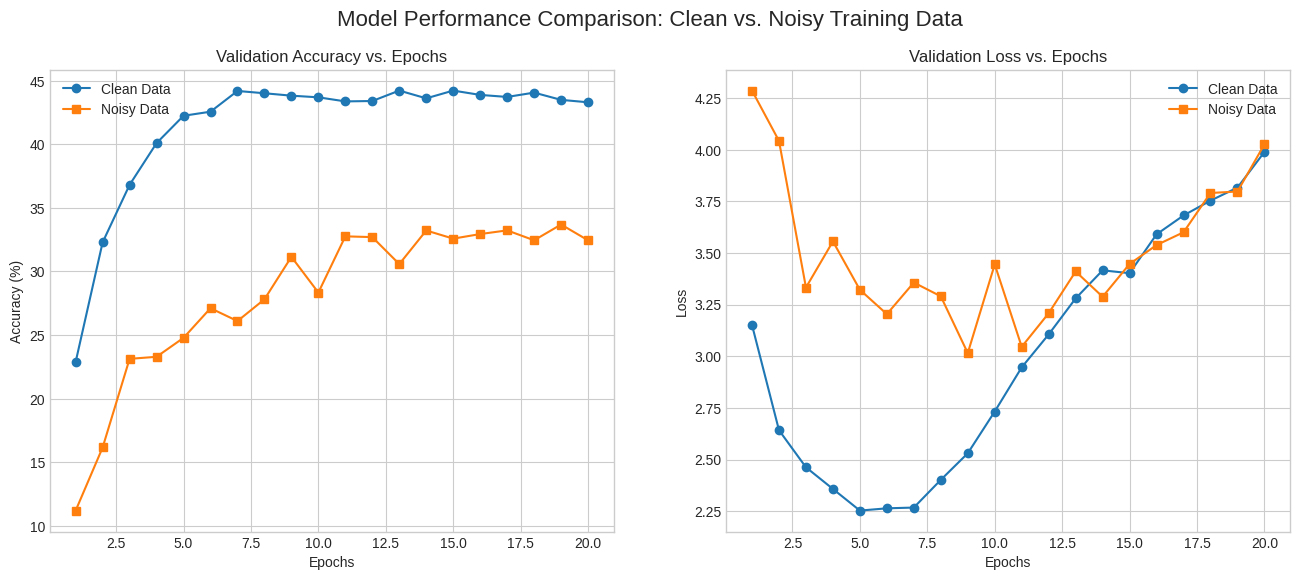

In [ ]:
epochs_range = range(1, NUM_EPOCHS + 1)

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


ax1.plot(epochs_range, history_clean['val_acc'], 'o-', label='Clean Data')
ax1.plot(epochs_range, history_noisy['val_acc'], 's-', label='Noisy Data')
ax1.set_title('Validation Accuracy vs. Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.legend()
ax1.grid(True)


ax2.plot(epochs_range, history_clean['val_loss'], 'o-', label='Clean Data')
ax2.plot(epochs_range, history_noisy['val_loss'], 's-', label='Noisy Data')
ax2.set_title('Validation Loss vs. Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.suptitle('Model Performance Comparison: Clean vs. Noisy Training Data', fontsize=16)
plt.show()


Neural Networks Assignment - Part 2:

In [13]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS_FINETUNE = 5
EPOCHS_SCRATCH = 10
num_classes = 102


In [14]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [15]:
image_datasets = {
    'train': datasets.Flowers102(root='./data', split='train', download=True, transform=data_transforms['train']),
    'val': datasets.Flowers102(root='./data', split='val', download=True, transform=data_transforms['val'])
}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=2) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [ ]:
def train_generic_model(model, criterion, optimizer, num_epochs=10):

    since = time.time()
    history = {'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            progress_bar = tqdm(dataloaders[phase], desc=phase, leave=False)
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    return history


In [ ]:
print("Fine-tuning the pre-trained ViT model")
model_finetune = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
num_ftrs = model_finetune.heads.head.in_features
model_finetune.heads.head = nn.Linear(num_ftrs, num_classes)
model_finetune = model_finetune.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_finetune = optim.SGD(model_finetune.parameters(), lr=LEARNING_RATE, momentum=0.9)
history_finetune = train_generic_model(model_finetune, criterion, optimizer_finetune, num_epochs=EPOCHS_FINETUNE)


Fine-tuning the pre-trained ViT model


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 141MB/s]


Epoch 1/5
----------


train Loss: 4.5790 Acc: 0.0265


val Loss: 4.3562 Acc: 0.0833
Epoch 2/5
----------


train Loss: 4.1384 Acc: 0.1647


val Loss: 3.8241 Acc: 0.3255
Epoch 3/5
----------


train Loss: 3.5403 Acc: 0.4137


val Loss: 3.2525 Acc: 0.4912
Epoch 4/5
----------


train Loss: 2.9457 Acc: 0.5853


val Loss: 2.7282 Acc: 0.6304
Epoch 5/5
----------


train Loss: 2.4312 Acc: 0.6941


val Loss: 2.3016 Acc: 0.6686
Training complete in 3m 60s


In [ ]:
print("Training the ViT model from scratch")
model_scratch = models.vit_b_16(weights=None)
num_ftrs = model_scratch.heads.head.in_features
model_scratch.heads.head = nn.Linear(num_ftrs, num_classes)
model_scratch = model_scratch.to(device)
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=LEARNING_RATE)
history_scratch = train_generic_model(model_scratch, criterion, optimizer_scratch, num_epochs=EPOCHS_SCRATCH)


Training the ViT model from scratch
Epoch 1/10
----------


train Loss: 5.0405 Acc: 0.0157


val Loss: 4.5534 Acc: 0.0363
Epoch 2/10
----------


train Loss: 4.4469 Acc: 0.0245


val Loss: 4.1817 Acc: 0.0490
Epoch 3/10
----------


train Loss: 4.1818 Acc: 0.0382


val Loss: 3.9092 Acc: 0.0755
Epoch 4/10
----------


train Loss: 3.9577 Acc: 0.0510


val Loss: 3.8078 Acc: 0.0794
Epoch 5/10
----------


train Loss: 3.8271 Acc: 0.0716


val Loss: 3.7484 Acc: 0.0951
Epoch 6/10
----------


train Loss: 3.8117 Acc: 0.0745


val Loss: 3.7007 Acc: 0.0794
Epoch 7/10
----------


train Loss: 3.7289 Acc: 0.0892


val Loss: 3.6957 Acc: 0.1059
Epoch 8/10
----------


train Loss: 3.6106 Acc: 0.0990


val Loss: 3.5433 Acc: 0.1078
Epoch 9/10
----------


train Loss: 3.6979 Acc: 0.0794


val Loss: 3.7588 Acc: 0.0912
Epoch 10/10
----------


train Loss: 3.6656 Acc: 0.0784


val Loss: 3.5072 Acc: 0.1176
Training complete in 8m 1s


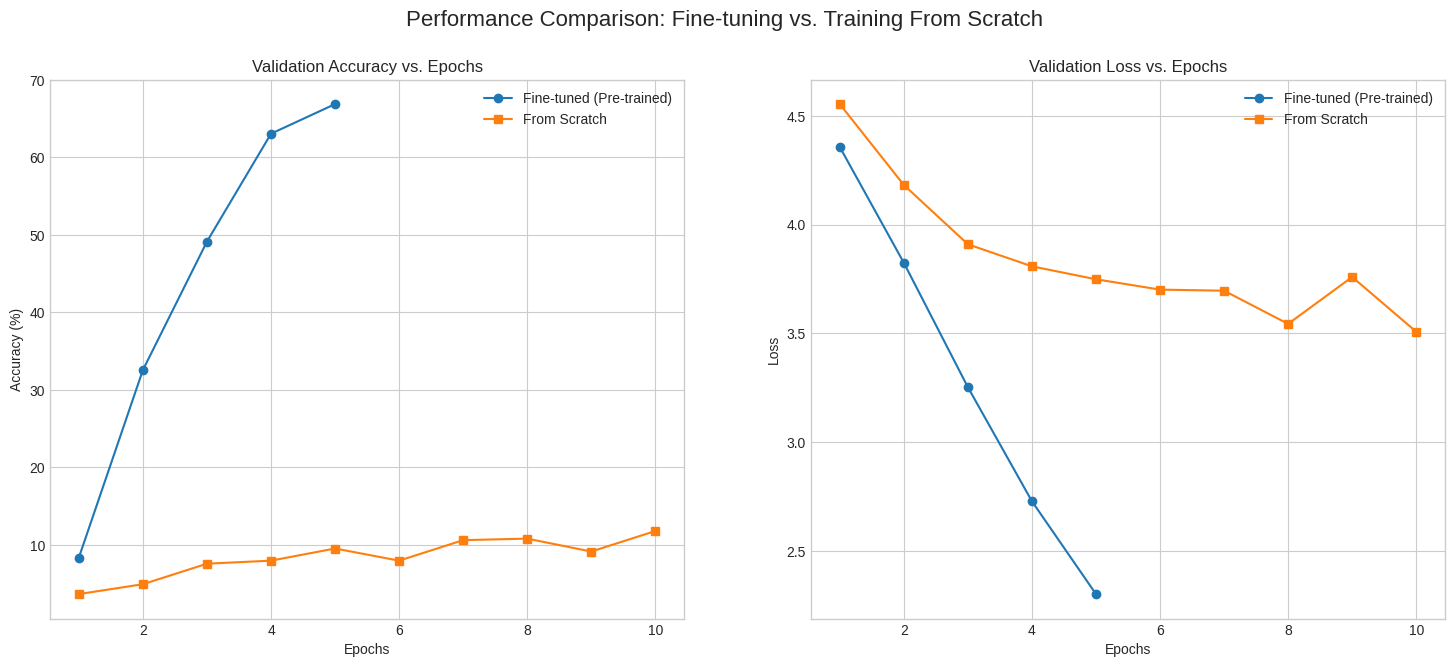

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))


epochs_finetune_range = range(1, EPOCHS_FINETUNE + 1)
epochs_scratch_range = range(1, EPOCHS_SCRATCH + 1)
acc_finetune = [h * 100 for h in history_finetune['val_acc']]
acc_scratch = [h * 100 for h in history_scratch['val_acc']]

ax1.plot(epochs_finetune_range, acc_finetune, 'o-', label='Fine-tuned (Pre-trained)')
ax1.plot(epochs_scratch_range, acc_scratch, 's-', label='From Scratch')
ax1.set_title('Validation Accuracy vs. Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.legend()


ax2.plot(epochs_finetune_range, history_finetune['val_loss'], 'o-', label='Fine-tuned (Pre-trained)')
ax2.plot(epochs_scratch_range, history_scratch['val_loss'], 's-', label='From Scratch')
ax2.set_title('Validation Loss vs. Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.suptitle('Performance Comparison: Fine-tuning vs. Training From Scratch', fontsize=16)
plt.show()


In [ ]:
# model_clean = models.resnet18(weights=None, num_classes=100).to(device)
# model_noisy = models.resnet18(weights=None, num_classes=100).to(device)
# model_finetune = models.vit_b_16(weights=None, num_classes=102)
# model_finetune.heads.head = nn.Linear(model_finetune.heads.head.in_features, 102)
# model_finetune = model_finetune.to(device)
# model_scratch = models.vit_b_16(weights=None, num_classes=102)
# model_scratch.heads.head = nn.Linear(model_scratch.heads.head.in_features, 102)
# model_scratch = model_scratch.to(device)

In [16]:
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])


In [17]:
test_dataset_cifar = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_cifar)
test_loader_cifar = torch.utils.data.DataLoader(test_dataset_cifar, batch_size=128, shuffle=False)


In [18]:
transform_flowers = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [19]:
test_dataset_flowers = datasets.Flowers102(root='./data', split='test', download=True, transform=transform_flowers)
test_loader_flowers = torch.utils.data.DataLoader(test_dataset_flowers, batch_size=32, shuffle=False)


In [20]:
def fgsm_attack(model, loss_fn, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    model.zero_grad()
    loss = loss_fn(outputs, labels)
    loss.backward()
    attack_images = images + epsilon * images.grad.sign()
    return attack_images

In [21]:
def pgd_attack(model, loss_fn, images, labels, epsilon, alpha, iters):
    original_images = images.clone().detach()

    for i in range(iters):
        images.requires_grad = True
        outputs = model(images)
        model.zero_grad()
        loss = loss_fn(outputs, labels)
        loss.backward()

        adv_images = images + alpha * images.grad.sign()
        eta = torch.clamp(adv_images - original_images, min=-epsilon, max=epsilon)
        images = torch.clamp(original_images + eta, min=-np.inf, max=np.inf).detach()

    return images

In [22]:
def evaluate_model(model, dataloader, attack_fn=None, attack_kwargs=None):
    model.eval()
    correct = 0
    total = 0
    loss_fn = nn.CrossEntropyLoss()

    for images, labels in tqdm(dataloader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)

        if attack_fn:
            images = attack_fn(model, loss_fn, images, labels, **attack_kwargs)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [ ]:
models_dict = {
    "ResNet-Clean": (model_clean, test_loader_cifar),
    "ResNet-Noisy": (model_noisy, test_loader_cifar),
    "ViT-Finetuned": (model_finetune, test_loader_flowers),
    "ViT-Scratch": (model_scratch, test_loader_flowers),
}

In [ ]:

results = {"Model": [], "Clean Acc (%)": [], "FGSM Acc (%)": [], "PGD Acc (%)": []}
fgsm_params = {'epsilon': 0.05}
pgd_params = {'epsilon': 0.05, 'alpha': 0.01, 'iters': 7}


In [ ]:
for name, (model, loader) in models_dict.items():
    print(f"\n--- Evaluating {name} ---")
    results["Model"].append(name)

    clean_acc = evaluate_model(model, loader)
    print(f"Accuracy on Clean Data: {clean_acc:.2f}%")
    results["Clean Acc (%)"].append(clean_acc)

    fgsm_acc = evaluate_model(model, loader, fgsm_attack, fgsm_params)
    print(f"Accuracy under FGSM Attack: {fgsm_acc:.2f}%")
    results["FGSM Acc (%)"].append(fgsm_acc)

    pgd_acc = evaluate_model(model, loader, pgd_attack, pgd_params)
    print(f"Accuracy under PGD Attack: {pgd_acc:.2f}%")
    results["PGD Acc (%)"].append(pgd_acc)


--- Evaluating ResNet-Clean ---


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 24.84it/s]


Accuracy on Clean Data: 43.30%


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 17.95it/s]


Accuracy under FGSM Attack: 6.10%


Evaluating: 100%|██████████| 79/79 [00:14<00:00,  5.57it/s]


Accuracy under PGD Attack: 2.74%

--- Evaluating ResNet-Noisy ---


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 21.22it/s]


Accuracy on Clean Data: 32.45%


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 17.89it/s]


Accuracy under FGSM Attack: 14.18%


Evaluating: 100%|██████████| 79/79 [00:14<00:00,  5.56it/s]


Accuracy under PGD Attack: 12.70%

--- Evaluating ViT-Finetuned ---


Evaluating: 100%|██████████| 193/193 [01:44<00:00,  1.85it/s]


Accuracy on Clean Data: 62.81%


Evaluating: 100%|██████████| 193/193 [05:13<00:00,  1.62s/it]


Accuracy under FGSM Attack: 5.81%


Evaluating: 100%|██████████| 193/193 [26:02<00:00,  8.10s/it]


Accuracy under PGD Attack: 0.83%

--- Evaluating ViT-Scratch ---


Evaluating: 100%|██████████| 193/193 [01:44<00:00,  1.85it/s]


Accuracy on Clean Data: 9.30%


Evaluating: 100%|██████████| 193/193 [05:13<00:00,  1.63s/it]


Accuracy under FGSM Attack: 5.33%


Evaluating: 100%|██████████| 193/193 [26:03<00:00,  8.10s/it]

Accuracy under PGD Attack: 2.60%


In [ ]:
import copy
defended_models_dict = {}

In [21]:
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_flowers = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset_cifar = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_cifar)
train_loader_cifar = torch.utils.data.DataLoader(train_dataset_cifar, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

train_dataset_flowers = datasets.Flowers102(root='./data', split='train', download=True, transform=transform_flowers)
train_loader_flowers = torch.utils.data.DataLoader(train_dataset_flowers, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print(f"CIFAR-100 training dataset loaded with {len(train_loader_cifar)} batches.")
print(f"102-Flowers training dataset loaded with {len(train_loader_flowers)} batches.")


CIFAR-100 training dataset loaded with 1563 batches.
102-Flowers training dataset loaded with 32 batches.


In [ ]:
def adversarial_train(model, dataloader, optimizer, num_epochs=10):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    adv_train_pgd_params = {'epsilon': 0.03, 'alpha': 0.01, 'iters': 7}

    print(f"Starting Adversarial Training for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        progress_bar = tqdm(dataloader, desc=f"Adv. Training Epoch {epoch+1}/{num_epochs}", leave=False)
        total_loss = 0
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            adv_images = pgd_attack(model, loss_fn, images, labels, **adv_train_pgd_params)

            optimizer.zero_grad()
            outputs = model(adv_images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Adversarial Loss: {avg_loss:.4f}")

    print("Adversarial Training Finished.")
    return model

In [ ]:
import copy

defended_models_dict = {}


def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

print("\n--- Training Defended ResNet-Clean ---")
model_clean_defended = copy.deepcopy(models_dict["ResNet-Clean"][0])
save_model(model_clean_defended, "/content/drive/MyDrive/resnet_clean.pth")
model_noisy_defended = copy.deepcopy(models_dict["ResNet-Noisy"][0])
save_model(model_noisy_defended, "/content/drive/MyDrive/resnet_noisy.pth")
model_finetune_defended = copy.deepcopy(models_dict["ViT-Finetuned"][0])
save_model(model_finetune_defended, "/content/drive/MyDrive/vit_finetuned.pth")
model_scratch_defended = copy.deepcopy(models_dict["ViT-Scratch"][0])
save_model(model_scratch_defended, "/content/drive/MyDrive/vit_scratch.pth")




optimizer = optim.Adam(model_clean_defended.parameters(), lr=1e-4)
adversarial_train(model_clean_defended, train_loader_cifar, optimizer, num_epochs=10)
defended_models_dict["ResNet-Clean-Defended"] = (model_clean_defended, test_loader_cifar)
save_model(model_clean_defended, "/content/drive/MyDrive/resnet_clean_defended.pth")


print("\n--- Training Defended ResNet-Noisy ---")

optimizer = optim.Adam(model_noisy_defended.parameters(), lr=1e-4)
adversarial_train(model_noisy_defended, train_loader_cifar, optimizer, num_epochs=10)
defended_models_dict["ResNet-Noisy-Defended"] = (model_noisy_defended, test_loader_cifar)
save_model(model_noisy_defended, "/content/drive/MyDrive/resnet_noisy_defended.pth")


print("\n--- Training Defended ViT-Finetuned ---")
optimizer = optim.Adam(model_finetune_defended.parameters(), lr=1e-5)
adversarial_train(model_finetune_defended, train_loader_flowers, optimizer, num_epochs=10)
defended_models_dict["ViT-Finetuned-Defended"] = (model_finetune_defended, test_loader_flowers)
save_model(model_finetune_defended, "/content/drive/MyDrive/vit_finetuned_defended.pth")



print("\n--- Training Defended ViT-Scratch ---")
optimizer = optim.Adam(model_scratch_defended.parameters(), lr=1e-5)
adversarial_train(model_scratch_defended, train_loader_flowers, optimizer, num_epochs=10)
defended_models_dict["ViT-Scratch-Defended"] = (model_scratch_defended, test_loader_flowers)
save_model(model_scratch_defended, "/content/drive/MyDrive/vit_scratch_defended.pth")

print("\nAll models have been adversarially trained.")


--- Training Defended ResNet-Clean ---
Model saved to /content/drive/MyDrive/resnet_clean.pth
Model saved to /content/drive/MyDrive/resnet_noisy.pth
Model saved to /content/drive/MyDrive/vit_finetuned.pth
Model saved to /content/drive/MyDrive/vit_scratch.pth
Starting Adversarial Training for 10 epochs...


Epoch 1/10, Average Adversarial Loss: 5.3362


Epoch 2/10, Average Adversarial Loss: 3.2006


Epoch 3/10, Average Adversarial Loss: 2.8597


Epoch 4/10, Average Adversarial Loss: 2.6523


Epoch 5/10, Average Adversarial Loss: 2.4857


Epoch 6/10, Average Adversarial Loss: 2.3410


Epoch 7/10, Average Adversarial Loss: 2.2230


Epoch 8/10, Average Adversarial Loss: 2.1099


Epoch 9/10, Average Adversarial Loss: 2.0128


Epoch 10/10, Average Adversarial Loss: 1.9210
Adversarial Training Finished.
Model saved to /content/drive/MyDrive/resnet_clean_defended.pth

--- Training Defended ResNet-Noisy ---
Starting Adversarial Training for 10 epochs...


Epoch 1/10, Average Adversarial Loss: 2.1104


Epoch 2/10, Average Adversarial Loss: 1.6472


Epoch 3/10, Average Adversarial Loss: 1.4811


Epoch 4/10, Average Adversarial Loss: 1.3646


Epoch 5/10, Average Adversarial Loss: 1.2777


Epoch 6/10, Average Adversarial Loss: 1.2076


Epoch 7/10, Average Adversarial Loss: 1.1448


Epoch 8/10, Average Adversarial Loss: 1.0980


Epoch 9/10, Average Adversarial Loss: 1.0371


Epoch 10/10, Average Adversarial Loss: 1.0023
Adversarial Training Finished.
Model saved to /content/drive/MyDrive/resnet_noisy_defended.pth

--- Training Defended ViT-Finetuned ---
Starting Adversarial Training for 10 epochs...


Epoch 1/10, Average Adversarial Loss: 3.4965


Epoch 2/10, Average Adversarial Loss: 2.7269


Epoch 3/10, Average Adversarial Loss: 2.4125


Epoch 4/10, Average Adversarial Loss: 2.1652


Epoch 5/10, Average Adversarial Loss: 1.9460


Epoch 6/10, Average Adversarial Loss: 1.7531


Epoch 7/10, Average Adversarial Loss: 1.5777


Epoch 8/10, Average Adversarial Loss: 1.4178


Epoch 9/10, Average Adversarial Loss: 1.2757


Epoch 10/10, Average Adversarial Loss: 1.1341
Adversarial Training Finished.
Model saved to /content/drive/MyDrive/vit_finetuned_defended.pth

--- Training Defended ViT-Scratch ---
Starting Adversarial Training for 10 epochs...


Epoch 1/10, Average Adversarial Loss: 3.7980


Epoch 2/10, Average Adversarial Loss: 3.6902


Epoch 3/10, Average Adversarial Loss: 3.6280


Epoch 4/10, Average Adversarial Loss: 3.5906


Epoch 5/10, Average Adversarial Loss: 3.5637


Epoch 6/10, Average Adversarial Loss: 3.5339


Epoch 7/10, Average Adversarial Loss: 3.5133


Epoch 8/10, Average Adversarial Loss: 3.4930


Epoch 9/10, Average Adversarial Loss: 3.4682


Epoch 10/10, Average Adversarial Loss: 3.4501
Adversarial Training Finished.
Model saved to /content/drive/MyDrive/vit_scratch_defended.pth

All models have been adversarially trained.


In [23]:
def create_model():
    model = torchvision.models.resnet18(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 100)
    return model.to(device)

In [24]:
model_clean_defended = create_model()
model_clean = create_model()
model_noisy_defended = create_model()
model_noisy =create_model()


model_finetune_defended = models.vit_b_16(weights=None)
num_ftrs = model_finetune_defended.heads.head.in_features
model_finetune_defended.heads.head = nn.Linear(num_ftrs, num_classes)
model_finetune_defended = model_finetune_defended.to(device)

model_finetune = models.vit_b_16(weights=None)
num_ftrs = model_finetune.heads.head.in_features
model_finetune.heads.head = nn.Linear(num_ftrs, num_classes)
model_finetune = model_finetune.to(device)


model_scratch_defended = models.vit_b_16(weights=None)
num_ftrs = model_scratch_defended.heads.head.in_features
model_scratch_defended.heads.head = nn.Linear(num_ftrs, num_classes)
model_scratch_defended = model_scratch_defended.to(device)


model_scratch = models.vit_b_16(weights=None)
num_ftrs = model_scratch.heads.head.in_features
model_scratch.heads.head = nn.Linear(num_ftrs, num_classes)
model_scratch = model_scratch.to(device)


In [ ]:
model_clean_defended= model_clean_defended.load_state_dict(torch.load("/content/drive/MyDrive/resnet_clean_defended.pth"))
model_clean = model_clean.load_state_dict(torch.load("/content/drive/MyDrive/resnet_clean.pth"))
model_noisy_defended = model_noisy_defended.load_state_dict(torch.load("/content/drive/MyDrive/resnet_noisy_defended.pth"))
model_noisy = model_noisy.load_state_dict(torch.load("/content/drive/MyDrive/resnet_noisy.pth"))
model_finetune_defended = model_finetune_defended.load_state_dict(torch.load("/content/drive/MyDrive/vit_finetuned_defended.pth"))
model_finetune =  model_finetune.load_state_dict(torch.load("/content/drive/MyDrive/vit_finetuned.pth"))
model_scratch_defended = model_scratch_defended.load_state_dict(torch.load("/content/drive/MyDrive/vit_scratch_defended.pth"))
model_scratch = model_scratch.load_state_dict(torch.load("/content/drive/MyDrive/vit_scratch.pth"))

In [25]:
model_clean_defended.load_state_dict(torch.load("/content/drive/MyDrive/resnet_clean_defended.pth"))
model_clean.load_state_dict(torch.load("/content/drive/MyDrive/resnet_clean.pth"))
model_noisy_defended.load_state_dict(torch.load("/content/drive/MyDrive/resnet_noisy_defended.pth"))
model_noisy.load_state_dict(torch.load("/content/drive/MyDrive/resnet_noisy.pth"))
model_finetune_defended.load_state_dict(torch.load("/content/drive/MyDrive/vit_finetuned_defended.pth"))
model_finetune.load_state_dict(torch.load("/content/drive/MyDrive/vit_finetuned.pth"))
model_scratch_defended.load_state_dict(torch.load("/content/drive/MyDrive/vit_scratch_defended.pth"))
model_scratch.load_state_dict(torch.load("/content/drive/MyDrive/vit_scratch.pth"))

<All keys matched successfully>

In [26]:
models_dict = {
    "ResNet-Clean": (model_clean, test_loader_cifar),
    "ResNet-Noisy": (model_noisy, test_loader_cifar),
    "ViT-Finetuned": (model_finetune, test_loader_flowers),
    "ViT-Scratch": (model_scratch, test_loader_flowers),
}

In [27]:
defended_models_dict = {}
defended_models_dict["ResNet-Clean-Defended"] = (model_clean_defended, test_loader_cifar)
defended_models_dict["ResNet-Noisy-Defended"] = (model_noisy_defended, test_loader_cifar)
defended_models_dict["ViT-Finetuned-Defended"] = (model_finetune_defended, test_loader_flowers)
defended_models_dict["ViT-Scratch-Defended"] = (model_scratch_defended, test_loader_flowers)

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

fgsm_params = {'epsilon': 0.1}
pgd_params = {'epsilon': 0.1, 'alpha': 0.02, 'iters': 7}

def evaluate_model_comprehensively(model_name, model, dataloader):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()

    clean_correct, total = 0, 0
    for images, labels in tqdm(dataloader, desc=f"Clean Eval: {model_name}", leave=False):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        clean_correct += (predicted == labels).sum().item()
    clean_acc = 100 * clean_correct / total

    fgsm_correct = 0
    for images, labels in tqdm(dataloader, desc=f"FGSM Eval: {model_name}", leave=False):
        images, labels = images.to(device), labels.to(device)
        adv_images = fgsm_attack(model, loss_fn, images, labels, **fgsm_params)
        with torch.no_grad():
            outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        fgsm_correct += (predicted == labels).sum().item()
    fgsm_acc = 100 * fgsm_correct / total

    pgd_correct = 0
    for images, labels in tqdm(dataloader, desc=f"PGD Eval: {model_name}", leave=False):
        images, labels = images.to(device), labels.to(device)
        adv_images = pgd_attack(model, loss_fn, images, labels, **pgd_params)
        with torch.no_grad():
            outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        pgd_correct += (predicted == labels).sum().item()
    pgd_acc = 100 * pgd_correct / total

    return {'Model': model_name, 'Clean Accuracy': clean_acc, 'FGSM Accuracy': fgsm_acc, 'PGD Accuracy': pgd_acc}

all_results = []

print("--- Evaluating Original Models ---")
for model_name, (model, loader) in models_dict.items():
    result = evaluate_model_comprehensively(model_name, model, loader)
    result['State'] = 'Original'
    all_results.append(result)

print("\n--- Evaluating Defended Models ---")
for model_name, (model, loader) in defended_models_dict.items():
    result = evaluate_model_comprehensively(model_name.replace('-Defended',''), model, loader)
    result['State'] = 'Defended'
    all_results.append(result)

final_df = pd.DataFrame(all_results)
final_df = final_df[['Model', 'State', 'Clean Accuracy', 'FGSM Accuracy', 'PGD Accuracy']]

print("\n\n--- FINAL COMPREHENSIVE RESULTS ---")
display(final_df)

--- Evaluating Original Models ---



--- Evaluating Defended Models ---




--- FINAL COMPREHENSIVE RESULTS ---


,Model,State,Clean Accuracy,FGSM Accuracy,PGD Accuracy
0,ResNet-Clean,Original,43.300000,1.920000,0.230000
1,ResNet-Noisy,Original,32.450000,7.180000,4.850000
2,ViT-Finetuned,Original,62.806960,2.455684,0.016263
3,ViT-Scratch,Original,9.302326,4.277118,1.512441
4,ResNet-Clean,Defended,33.360000,5.810000,3.830000
5,ResNet-Noisy,Defended,23.280000,3.800000,2.480000
6,ViT-Finetuned,Defended,78.549358,23.060660,11.140023
7,ViT-Scratch,Defended,14.912994,8.440397,3.545292


In [28]:
!pip install grad-cam opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.2 MB/

In [28]:
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import cv2
import matplotlib.pyplot as plt

def tensor_to_img(tensor, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)

    img_np = tensor.cpu().numpy().transpose(1, 2, 0)
    img_np = np.clip(img_np, 0, 1)
    return img_np


def reshape_transform_vit(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

--- Visualizing ResNet Models ---


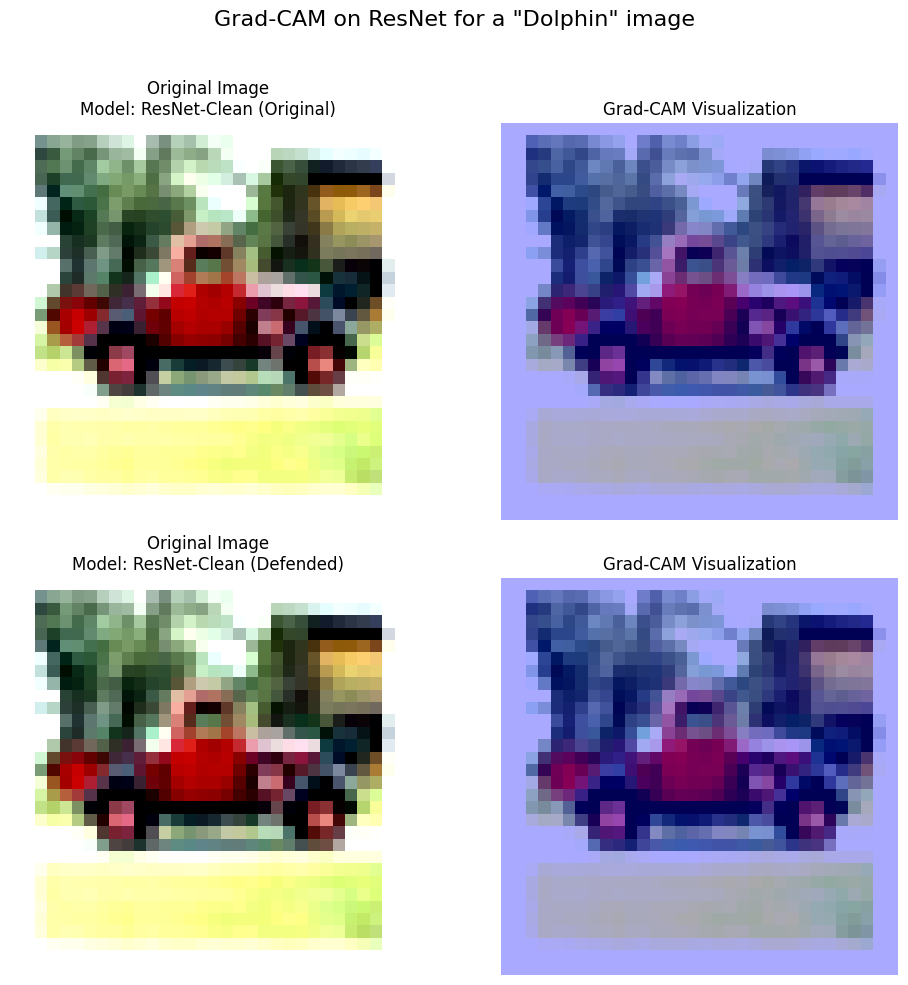

In [30]:


print("--- Visualizing ResNet Models ---")


resnet_models_to_viz = {
    "ResNet-Clean (Original)": models_dict["ResNet-Clean"][0],
    "ResNet-Clean (Defended)": defended_models_dict["ResNet-Clean-Defended"][0]
}

sample_img_tensor, sample_label = test_dataset_cifar[150]
input_tensor = sample_img_tensor.unsqueeze(0).to(device)


fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Grad-CAM on ResNet for a "Dolphin" image', fontsize=16)

for i, (model_name, model) in enumerate(resnet_models_to_viz.items()):
    model.eval()


    target_layers_resnet = [model.layer4]

    cam = GradCAM(model=model, target_layers=target_layers_resnet)

    targets = [ClassifierOutputTarget(sample_label)]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    vis_img = tensor_to_img(sample_img_tensor.clone(), mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

    cam_image = show_cam_on_image(vis_img, grayscale_cam, use_rgb=True)

    axs[i, 0].imshow(vis_img)
    axs[i, 0].set_title(f"Original Image\nModel: {model_name}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(cam_image)
    axs[i, 1].set_title("Grad-CAM Visualization")
    axs[i, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


--- Visualizing ViT Models ---


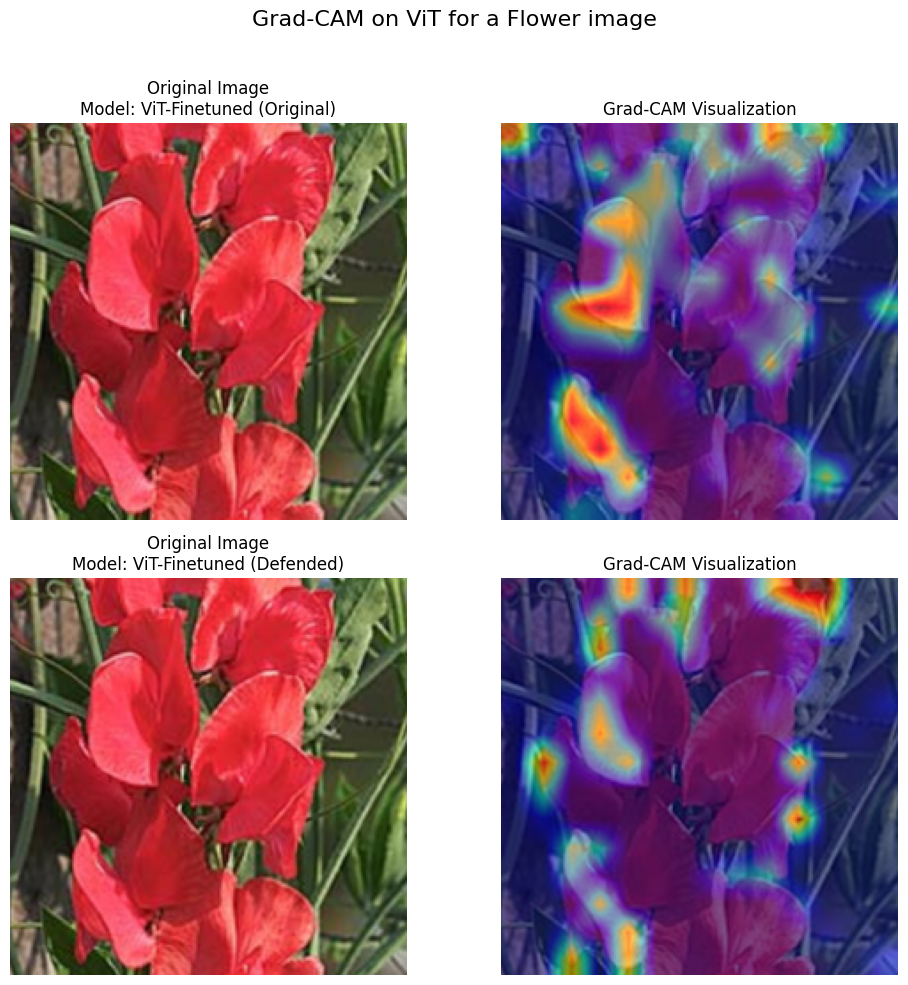

In [32]:

print("\n--- Visualizing ViT Models ---")

vit_models_to_viz = {
    "ViT-Finetuned (Original)": models_dict["ViT-Finetuned"][0],
    "ViT-Finetuned (Defended)": defended_models_dict["ViT-Finetuned-Defended"][0]
}


sample_img_tensor_flower, sample_label_flower = test_dataset_flowers[100]
input_tensor_flower = sample_img_tensor_flower.unsqueeze(0).to(device)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Grad-CAM on ViT for a Flower image', fontsize=16)

for i, (model_name, model) in enumerate(vit_models_to_viz.items()):
    model.eval()

    target_layers_vit = [model.encoder.layers[-1].ln_1]

    cam = GradCAM(model=model,
                  target_layers=target_layers_vit,
                  reshape_transform=reshape_transform_vit)

    targets = [ClassifierOutputTarget(sample_label_flower)]
    grayscale_cam = cam(input_tensor=input_tensor_flower, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    vis_img_flower = tensor_to_img(sample_img_tensor_flower.clone(), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    cam_image = show_cam_on_image(vis_img_flower, grayscale_cam, use_rgb=True)

    axs[i, 0].imshow(vis_img_flower)
    axs[i, 0].set_title(f"Original Image\nModel: {model_name}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(cam_image)
    axs[i, 1].set_title("Grad-CAM Visualization")
    axs[i, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()